In [94]:
## Started on May 7, 2021 at 1 PM CT
## Goal: don't use pyspeckit right now

# Import statements
%matplotlib inline
from spectral_cube import SpectralCube
from spectral_cube.dask_spectral_cube import DaskSpectralCube
from astroquery.splatalogue import Splatalogue
from astropy import units as u
from astropy import constants
from lte_modeling_tools import nupper_of_kkms
from pylab import imshow
import numpy as np
from scipy.optimize import curve_fit
import time
import matplotlib.pyplot as plt
import pylab as pl
from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import quantity_support
quantity_support()

# Check some things
import sys
sys.executable
import dask
dask.__version__ # My dask version was old but now it is updated

'2021.04.1'

In [2]:
# Import cube
results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'
freq_spw = '146_spw51'
fn = results+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image'
cube = SpectralCube.read(fn, format='casa_image', use_dask=True) # Import cube
freq_lo, freq_hi = 147.01*u.GHz, 147.17*u.GHz # Rough frequencies to search between
rough_subcube = cube.spectral_slab(freq_lo, freq_hi) # Generate rough subcube from cube
rough_subcube = rough_subcube.to(u.K) # Convert from Jy/beam to brightness temperature
print(rough_subcube) # Print metadata about rough subcube

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/casa_formats_io-0.1-py3.7-linux-x86_64.egg/casa_formats_io/casa_dask.py:232: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


DaskVaryingResolutionSpectralCube with shape=(329, 512, 512) and unit=K and chunk size (255, 128, 128):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
 n_s:    329  type_s: FREQ      unit_s: Hz     range: 147009887391.829 Hz:147170048296.150 Hz


In [50]:
# Calculate the MAD-estimated RMS value for the rough subcube (can't do on original cube)
start = time.time()
sigma = np.nanmedian(rough_subcube.mad_std(axis = 0))
# sigma_subcube = sigma/np.sqrt(rough_subcube.shape[0]*rough_subcube.shape[1]*rough_subcube.shape[2])
sigma_subcube = sigma # Try this way, as slopes are... very bad
print(sigma_subcube)
print("Sigma calculation:", time.time() - start, "seconds")

0.06657724331725512 K
Sigma calculation: 46.63187646865845 seconds


In [51]:
# Retrieve center frequecies for lines from Splatalogue
tbl = Splatalogue.query_lines(freq_lo-0.1*u.GHz, freq_hi+0.1*u.GHz, 
                              chemical_name='CH3CN',
                              energy_max=500, # Get more lines w/ max energy > 140
                              energy_type='eu_k',
                              line_lists=['JPL'],
                              show_upper_degeneracy=True, 
                              show_qn_code=True)
tbl_trimmed = tbl[tbl['Quantum Number Code']==202]
tbl_trimmed = tbl_trimmed[::-1]
line_freqs = tbl_trimmed['Freq-GHz(rest frame,redshifted)'].data
shifted_line_freqs = line_freqs-((40.5/299792)*line_freqs) # Shift by velocity, here 40.5 km/s
einstein_A_coefficients = tbl_trimmed['Log<sub>10</sub> (A<sub>ij</sub>)'].data
E_upper = tbl_trimmed['E_U (K)'].data
g = tbl_trimmed['Upper State Degeneracy'].data

# Get subcube for each transition
slab_width = 2.315*u.km/u.s
subcubes = []
i = 0
for line in shifted_line_freqs:
    slab = rough_subcube.with_spectral_unit(u.km/u.s, rest_value = line*u.GHz,
                                            velocity_convention = 'radio').spectral_slab(-slab_width, 
                                                                                         slab_width)
    print(slab)
    subcubes.append(slab)
    i += 1

DaskVaryingResolutionSpectralCube with shape=(6, 512, 512) and unit=K and chunk size (6, 128, 128):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
 n_s:      6  type_s: VRAD      unit_s: km / s  range:       -2.408 km / s:       2.566 km / s
DaskVaryingResolutionSpectralCube with shape=(6, 512, 512) and unit=K and chunk size (6, 128, 128):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
 n_s:      6  type_s: VRAD      unit_s: km / s  range:       -2.217 km / s:       2.757 km / s
DaskVaryingResolutionSpectralCube with shape=(6, 512, 512) and unit=K and chunk size (6, 128, 128):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg

In [52]:
# Calculate the channel width
axis = rough_subcube.with_spectral_unit(u.km/u.s, rest_value = line*u.GHz, 
                                        velocity_convention = 'radio').spectral_axis
channel_width = np.abs(axis[1] - axis[0])
channel_width

<Quantity 0.99572372 km / s>

In [53]:
# Get moment 0 map for each transition
mom0s = []
for sc in subcubes:
    moment_0 = sc.moment(order = 0)
    mom0s.append(moment_0) # These moment 0 maps now have units of K*km/s
# Propagate error on integrated intensity
sigma_int = sigma_subcube*(channel_width)
sigma_int

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/radio_beam-0.3.3-py3.7.egg/radio_beam/multiple_beams.py:265: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/radio_beam-0.3.3-py3.7.egg/radio_beam/multiple_beams.py:265: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/radio_beam-0.3.3-py3.7.egg/radio_beam/multiple_beams.py:265: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages

<Quantity 0.06629254 K km / s>

In [54]:
# Calculate upper state column density from integrated line intensity
i = 0
N_upper_maps = []
for mom0_map in mom0s:
    # Here, we just pass integrated intensity = mom0_map, since mom0 is data units (K) * dx (km/s)
    N_upper = nupper_of_kkms(mom0_map, shifted_line_freqs[i], 10**(einstein_A_coefficients[i]))
    N_upper_maps.append(N_upper)
    i += 1
N_upper_maps = np.array(N_upper_maps)

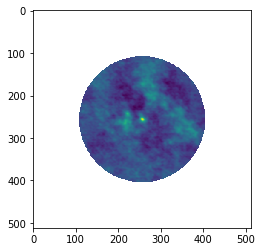

In [55]:
# Visualize the moment0 maps
imshow(N_upper_maps[0])

In [56]:
# Define a linear function
def linear(x, m, b):
        return (m*x) + b

In [83]:
# Propagate error from integrated intensity to upper state column density
sigma_N_uppers = []
for i in range(len(shifted_line_freqs)):
    freq = shifted_line_freqs[i]*u.GHz # Adapted from lte_modeling_tools.py
    Aul = (10**(einstein_A_coefficients[i]))*u.Hz
    sigma_kkms = sigma_int.to(u.K*u.km/u.s) 
    nline = 8*np.pi*freq*constants.k_B/constants.h/Aul/constants.c**2
    sigma_Khz = (sigma_kkms*(freq/constants.c)).to(u.K * u.MHz)
    sigma_N_upper = (nline*sigma_Khz).to(u.cm**-2)
    sigma_N_uppers.append(sigma_N_upper.value)
sigma_N_uppers

[15073634376.352093,
 15316912696.767818,
 16080924894.127584,
 17546776766.321598,
 20106211333.451702,
 24753107891.75959,
 34483065752.029816,
 64388558536.16009]

In [113]:
# Perform fitting (bad way)
start = time.time()
temp_map = np.empty((rough_subcube.shape[1], rough_subcube.shape[2]))
temp_map[:] = np.nan # Initialize temperature map with all NaNs
for i in range(rough_subcube.shape[1]): # Loop over x-axis of cube
    for j in range(rough_subcube.shape[2]): # Loop over y-axis of cube
        if (N_upper_maps[-4, i, j])/(u.cm**2) > 3.*sigma_N_uppers[-4]/(u.cm**2): # Only fit if the J = 3 detected
            N_vals = N_upper_maps[:, i, j] # Extract N_upper values in pixel along transitions axis
            N_vals_for_fit = N_vals # Initialize array of N_upper values we're going to fit
            for ind in range(len(N_vals_for_fit)): # Only fit lines above 3*sigma 
                if N_vals_for_fit[ind]/(u.cm**2) < 3.*sigma_N_uppers[ind]/(u.cm**2):
                    N_vals_for_fit[ind] = np.nan # Replace "undetected" lines with NaN so they're not fit
            valid = ~np.isnan(N_vals_for_fit) # Make mask for values to be used in fit
            
#             fig = plt.figure(figsize=(7, 7))
#             plt.scatter(E_upper, np.log10(N_vals_for_fit/g))
#             plt.ylabel("$\log (N_u / g)$")
#             plt.xlabel("$E_u / k$ (K)")
#             plt.show()
            
            if len(N_vals_for_fit[valid]) > 4:
                sigma_y = sigma_N_uppers/(N_vals_for_fit*np.log(10.))
                popt, pcov = curve_fit(linear, xdata = E_upper[valid], 
                                       ydata = np.log10(N_vals_for_fit[valid]/g[valid]), 
                                       sigma = sigma_y[valid])
                if (1/popt[0] < 0.) and (1/popt[0] > -150.): # Only keep "good" temperatures (negative slopes)
                    temp_map[i, j] = -1./popt[0] # Put fitted temp into temp map
print("Fitting took", time.time() - start, "seconds")

Fitting took 70.13511919975281 seconds


345


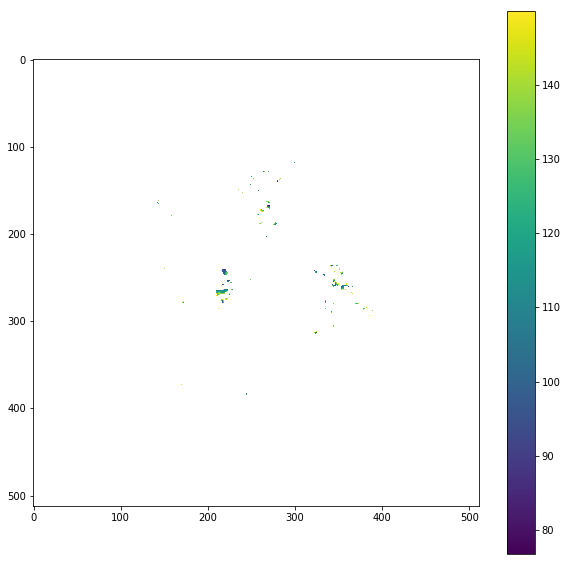

In [114]:
# Visualize temperature map (made with the bad way)
print(np.count_nonzero(~np.isnan(temp_map)))
# norm = simple_norm(temp_map, 'sqrt', percent=70)
fig = plt.figure(figsize=(10, 10))
plt.imshow(temp_map) # cmap='Greys_r', norm=norm, interpolation='nearest'
plt.colorbar() 
# That ain't right

[[[0.  ]]

 [[0.25]]

 [[0.5 ]]

 [[0.75]]

 [[1.  ]]]
ffw.shape=(5, 391), zz1d.shape=(5, 2)
rank=2, singular=[1.65057737 0.3160785 ]


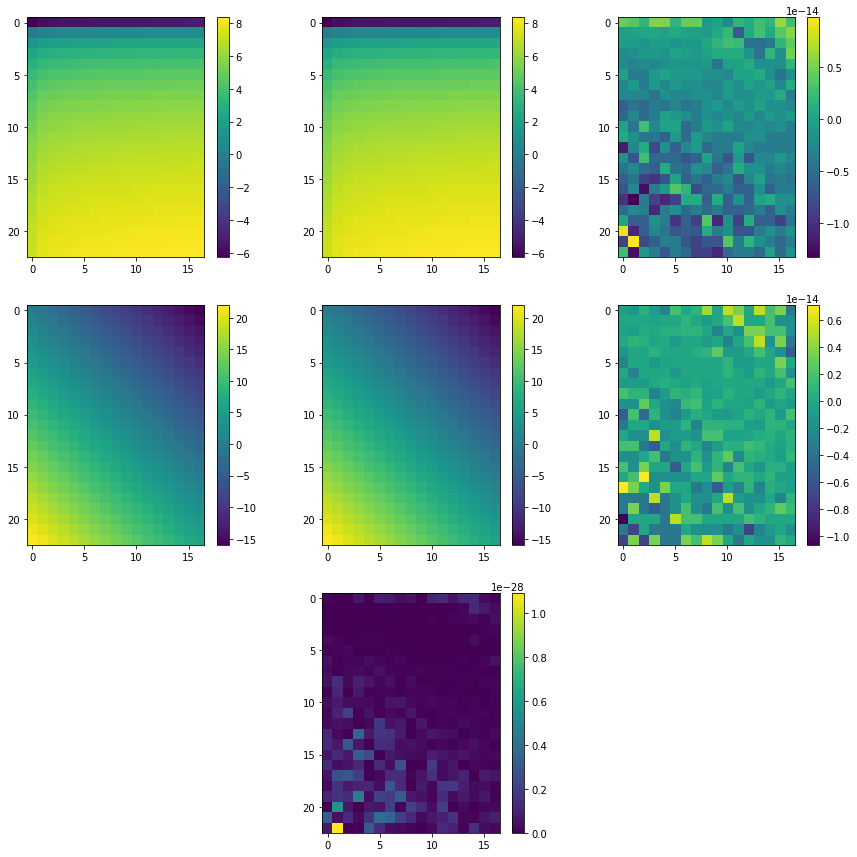

In [41]:
# Perform fitting (good way, with linear algebra; from Adam)
# start = time.time()
# temp_map = np.empty((rough_subcube.shape[1], rough_subcube.shape[2]))
# temp_map[:] = np.nan # Initialize temperature map with all NaNs
# for i in range(rough_subcube.shape[1]): # Loop over x-axis of cube
#     for j in range(rough_subcube.shape[2]): # Loop over y-axis of cube
#         if (N_upper_maps[-4, i, j])/(u.cm**2) > 3.*sigma_N_uppers[-4]: # Only fit if the J = 3 detected
#             N_vals = N_upper_maps[:, i, j] # Extract N_upper values in pixel along transitions axis
#             N_vals_for_fit = N_vals # Initialize array of N_upper values we're going to fit
#             for ind in range(len(N_vals_for_fit)): # Only fit lines above 3*sigma 
#                 if N_vals_for_fit[ind]/(u.cm**2) < 3.*sigma_N_upper:
#                     N_vals_for_fit[ind] = np.nan # Replace "undetected" lines with NaN so they're not fit
#             valid = ~np.isnan(N_vals_for_fit) # Make mask for values to be used in fit
#             if len(np.log10(N_vals_for_fit/g)[valid]) != 0:
#                 sigma_y = sigma_N_upper/(N_vals_for_fit*np.log(10.))
#                 popt, pcov = curve_fit(linear, xdata = E_upper[valid], 
#                                        ydata = np.log10(N_vals_for_fit[valid]/g[valid]), 
#                                        sigma = sigma_y[valid])
#                 print(1./popt[0])
#                 temp_map[i, j] = 1./popt[0] # Put fitted temp into temp map
# print("Fitting took", time.time() - start, "seconds")


# make x,y axes
yy,xx = np.indices([23,17])
zz = np.linspace(0,1,5)[:,None,None]
print(zz)
# this works *if and only if* the weights are dependent on the Z-axis, but not the X- or Y- axis
weights = np.random.rand(zz.shape[0])
# f = mm * zz + bb
## mm, bb are arbitrarily selected
mm = 0.5 * np.log10(xx+0.1) + 2.5 * np.log(yy+0.1)
bb = yy-xx
ff = mm*zz + bb
zz1d = np.array([zz[:,0,0], np.ones(zz.shape[0])]).T
fitshape = ff.shape[0], np.product(ff.shape[1:])
ffr = ff.reshape(fitshape)
ffw = ffr * weights[:,None]
zzw = zz1d * weights[:,None]
print(f"ffw.shape={ffw.shape}, zz1d.shape={zz1d.shape}")
fitted, residuals, rank, singular = np.linalg.lstsq(zzw, ffw, rcond=None)
print(f"rank={rank}, singular={singular}")
fitted_m = fitted[0].reshape(ff.shape[1:])
fitted_b = fitted[1].reshape(ff.shape[1:])
fitted_resid = residuals.reshape(ff.shape[1:])
# verify again
_=pl.figure(figsize=(15,15))
im=pl.subplot(3,3,1).imshow(mm); pl.colorbar(mappable=im)
im=pl.subplot(3,3,2).imshow(fitted_m); pl.colorbar(mappable=im)
im=pl.subplot(3,3,3).imshow(fitted_m-mm); pl.colorbar(mappable=im)
im=pl.subplot(3,3,4).imshow(bb); pl.colorbar(mappable=im)
im=pl.subplot(3,3,5).imshow(fitted_b); pl.colorbar(mappable=im)
im=pl.subplot(3,3,6).imshow(fitted_b-bb); pl.colorbar(mappable=im)
im=pl.subplot(3,3,8).imshow(fitted_resid); pl.colorbar(mappable=im)